In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

In [2]:
N_SHUFFLES = 2
N_PREV = 1
N_DISCRETIZATION = 101
CLIP_POINT = 0.2

# Data preparation

In [3]:
data = pd.read_feather('data/pivoted/tracking_week_4.feather')
data.dropna(axis=0, how='any', inplace=True)
fixed_cols = ['gameId', 'playId', 'frameId'] + [col for col in data.columns if col.endswith(('_dx', '_dy'))]
player_cols = [col for col in data.columns if col.endswith(('_x', '_y'))]

data = pd.concat(
    [data[fixed_cols]] + 
    [data[player_cols].shift(i) for i in range(1, N_PREV + 1)]
, axis=1)

data.columns = fixed_cols + [f'{col}-{i}' for i in range(1, N_PREV + 1) for col in player_cols]
data.dropna(axis=0, how='any', inplace=True)

In [4]:
ball_pair = [item for sublist in [[f'p0_x-{j}', f'p0_y-{j}'] for j in range(1, N_PREV + 1)] for item in sublist]
player_pairs = []
for i in range(1, 23):
    pair = []
    for j in range(1, N_PREV + 1):
        pair += [f'p{i}_x-{j}', f'p{i}_y-{j}']
    player_pairs.append(pair)

In [5]:
def shuffle_pairs(pairs, remove_id=None):
    if remove_id is None:
        tmp_list = pairs
    else:
        tmp_list = pairs[:remove_id] + pairs[remove_id + 1:]
    np.random.shuffle(tmp_list)
    return tmp_list

In [6]:
X, Y, X_ball_flag = [], [], []
for p_id in range(1, 23):
    for _ in range(N_SHUFFLES):
        X.append(data[sum([ball_pair] + [player_pairs[p_id-1]] + shuffle_pairs(player_pairs, p_id-1), [])].values)
        X_ball_flag.append(np.zeros((X[-1].shape[0], 1)))
        Y.append(data[[f'p{p_id}_dx', f'p{p_id}_dy']].values)

# Add ball
for _ in range(N_SHUFFLES):
    X.append(data[sum([ball_pair] + shuffle_pairs(player_pairs, None), [])].values)
    X_ball_flag.append(np.ones((X[-1].shape[0], 1)))
    Y.append(data[['p0_dx', 'p0_dy']].values)

X = np.concatenate(X, axis=0)
X_ball_flag = np.concatenate(X_ball_flag, axis=0)
X = np.concatenate([X, X_ball_flag], axis=1)
Y = np.concatenate(Y, axis=0).clip(-CLIP_POINT, CLIP_POINT)

In [7]:
bins = np.linspace(-CLIP_POINT, CLIP_POINT, N_DISCRETIZATION)
Y = np.digitize(Y, bins) - 1

In [8]:
discretization_dict = dict(enumerate(bins))

def undiscretize(discretized_value):
    return discretization_dict[discretized_value]
undiscretize_vec = np.vectorize(undiscretize)

#EXAMPLE: Y = undiscretize_vec(Y)

# Modeling

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2217052, 47), (554264, 47), (2217052, 2), (554264, 2))

In [10]:
class DualOutputNet(nn.Module):
    def __init__(self, input_size, n_discretization):
        super(DualOutputNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        # self.fc2 = nn.Linear(256, 256)
        # self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(128, 64)
        self.fc5_1 = nn.Linear(64, n_discretization)
        self.fc5_2 = nn.Linear(64, n_discretization)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        # self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)
                init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        # x = self.relu(self.fc2(x))
        # x = self.dropout(x)
        # x = self.relu(self.fc3(x))
        # x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        # out1 = self.softmax(self.fc5_1(x))
        # out2 = self.softmax(self.fc5_2(x))

        out1 = self.sigmoid(self.fc5_1(x))
        out2 = self.sigmoid(self.fc5_2(x))

        return torch.cat((out1, out2), dim=1)
    
def cyclic_cosine_annealing_lr(lr, T_max, eta_min=0, last_epoch=-1):
    if last_epoch == 0:
        return lr

    if last_epoch % (2 * T_max) < T_max:
        return (
            eta_min
            + (lr - eta_min)
            * (1 + torch.cos(torch.tensor(3.1415 * last_epoch / T_max)))
            / 2
        )
    else:
        return (
            eta_min
            + (lr - eta_min)
            * (1 + torch.cos(torch.tensor(3.1415 * (last_epoch - T_max) / T_max)))
            / 2
        )

In [11]:
X_train = torch.FloatTensor(X_train)
Y_train = torch.LongTensor(Y_train)
X_test = torch.FloatTensor(X_test)
Y_test = torch.LongTensor(Y_test)

In [12]:
input_size = X_train.shape[1]
num_classes = N_DISCRETIZATION
model = DualOutputNet(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
learning_rate_init = 0.001
num_epochs = 10
batch_size = 1024

In [13]:
losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    lr_update = cyclic_cosine_annealing_lr(learning_rate_init, num_epochs, 0, epoch)
    optimizer = optim.Adam(model.parameters(), lr=lr_update)
    
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = Y_train[i:i+batch_size]
        
        # Forward pass
        outputs = model(batch_X)
        loss1 = criterion(outputs[:, :N_DISCRETIZATION], batch_y[:, 0])
        loss2 = criterion(outputs[:, N_DISCRETIZATION:], batch_y[:, 1])
        loss = loss1 + loss2
        losses.append(loss.item())
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # if (epoch + 1) % 10 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

100%|██████████| 10/10 [02:09<00:00, 12.93s/it]


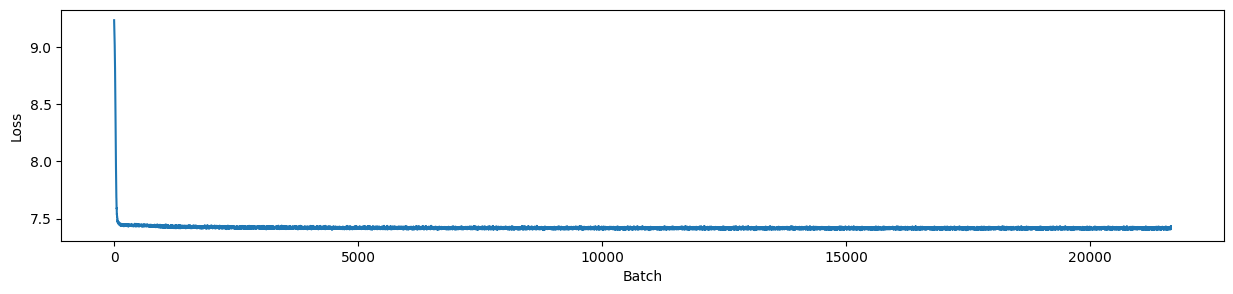

In [14]:
plt.rcParams['figure.figsize'] = [15, 3]
plt.plot(losses);
# plt.plot(pd.Series(losses).rolling(window=1000, min_periods=1).mean());
plt.xlabel('Batch');
plt.ylabel('Loss');

In [15]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    
    # Split the outputs into two sets of probabilities
    probs1 = test_outputs[:, :N_DISCRETIZATION]
    probs2 = test_outputs[:, N_DISCRETIZATION:]
    
    # Get the predicted classes
    _, predicted1 = torch.max(probs1, 1)
    _, predicted2 = torch.max(probs2, 1)
    
    # Calculate accuracy for both outputs
    accuracy1 = (predicted1 == Y_test[:, 0]).float().mean()
    accuracy2 = (predicted2 == Y_test[:, 1]).float().mean()
    print(f'Test Accuracy - Output 1: {accuracy1.item():.4f}, Output 2: {accuracy2.item():.4f}')

    # Create DataFrames with the probabilities
    df_probs1 = pd.DataFrame(probs1.numpy(), columns=[f'Out1_Class_{i}' for i in range(N_DISCRETIZATION)])
    df_probs2 = pd.DataFrame(probs2.numpy(), columns=[f'Out2_Class_{i}' for i in range(N_DISCRETIZATION)])
    
    # Combine the DataFrames
    df_probabilities = pd.concat([df_probs1, df_probs2], axis=1)
    
    # Add the true classes and predicted classes
    df_probabilities['True_Class1'] = Y_test[:, 0].numpy()
    df_probabilities['True_Class2'] = Y_test[:, 1].numpy()
    df_probabilities['Predicted_Class1'] = predicted1.numpy()
    df_probabilities['Predicted_Class2'] = predicted2.numpy()

Test Accuracy - Output 1: 0.1018, Output 2: 0.1090


In [16]:
df_probabilities.sample(8)

,Out1_Class_0,Out1_Class_1,Out1_Class_2,Out1_Class_3,Out1_Class_4,Out1_Class_5,Out1_Class_6,Out1_Class_7,Out1_Class_8,Out1_Class_9,...,Out2_Class_95,Out2_Class_96,Out2_Class_97,Out2_Class_98,Out2_Class_99,Out2_Class_100,True_Class1,True_Class2,Predicted_Class1,Predicted_Class2
417840,7.340076e-11,6.347062e-11,8.097310e-11,6.304724e-11,7.797481e-11,6.752664e-11,7.618989e-11,6.138094e-11,5.124541e-11,7.069014e-11,...,7.991000e-11,5.919758e-11,4.949786e-11,7.632064e-11,7.488930e-11,6.248160e-11,50,51,48,48
199985,9.646310e-10,7.831722e-10,3.757228e-10,6.257346e-10,3.779438e-10,7.215278e-10,4.492467e-10,5.788556e-10,5.587096e-10,7.493178e-10,...,4.508295e-10,7.393756e-10,5.497005e-10,5.351610e-10,5.253619e-10,3.940427e-10,50,51,48,48
181237,1.042562e-12,7.408990e-13,8.174799e-13,5.650779e-13,9.875748e-13,3.757323e-13,5.722222e-13,8.674056e-13,8.364574e-13,9.902344e-13,...,7.878470e-13,3.162529e-13,6.830235e-13,5.525862e-13,1.103888e-12,3.843162e-13,48,48,48,48
542434,2.612257e-08,2.913393e-08,3.317567e-08,2.635362e-08,3.139488e-08,2.797906e-08,2.733755e-08,3.046967e-08,2.696412e-08,2.687530e-08,...,2.953279e-08,2.872167e-08,3.229357e-08,3.265087e-08,3.376374e-08,3.440486e-08,50,49,48,48
49827,1.612089e-08,1.491821e-08,1.589250e-08,1.827472e-08,1.562130e-08,1.576083e-08,1.699192e-08,1.678339e-08,1.814372e-08,2.231664e-08,...,1.770645e-08,1.568184e-08,2.251223e-08,1.572590e-08,1.556978e-08,1.417280e-08,50,50,48,48
252807,3.651378e-12,2.164092e-12,2.403894e-12,1.499520e-12,3.210202e-12,1.357052e-12,1.743806e-12,2.614808e-12,2.122842e-12,3.299034e-12,...,2.228567e-12,1.141622e-12,1.817631e-12,2.348365e-12,3.753285e-12,1.623596e-12,50,49,48,48
80253,9.300351e-24,4.306773e-24,3.610090e-24,1.058429e-23,1.745879e-23,9.549342e-25,8.788013e-24,1.002819e-23,4.624602e-24,1.144443e-23,...,2.307828e-24,8.905686e-25,1.032322e-23,5.350836e-24,3.591259e-24,2.377156e-24,49,48,48,47
201937,1.894556e-12,2.059991e-12,1.320989e-12,1.527117e-12,1.755844e-12,2.119921e-12,1.120372e-12,2.820915e-12,1.641344e-12,1.612686e-12,...,1.990817e-12,2.425356e-12,1.444525e-12,1.737461e-12,1.881907e-12,1.387314e-12,50,50,48,48


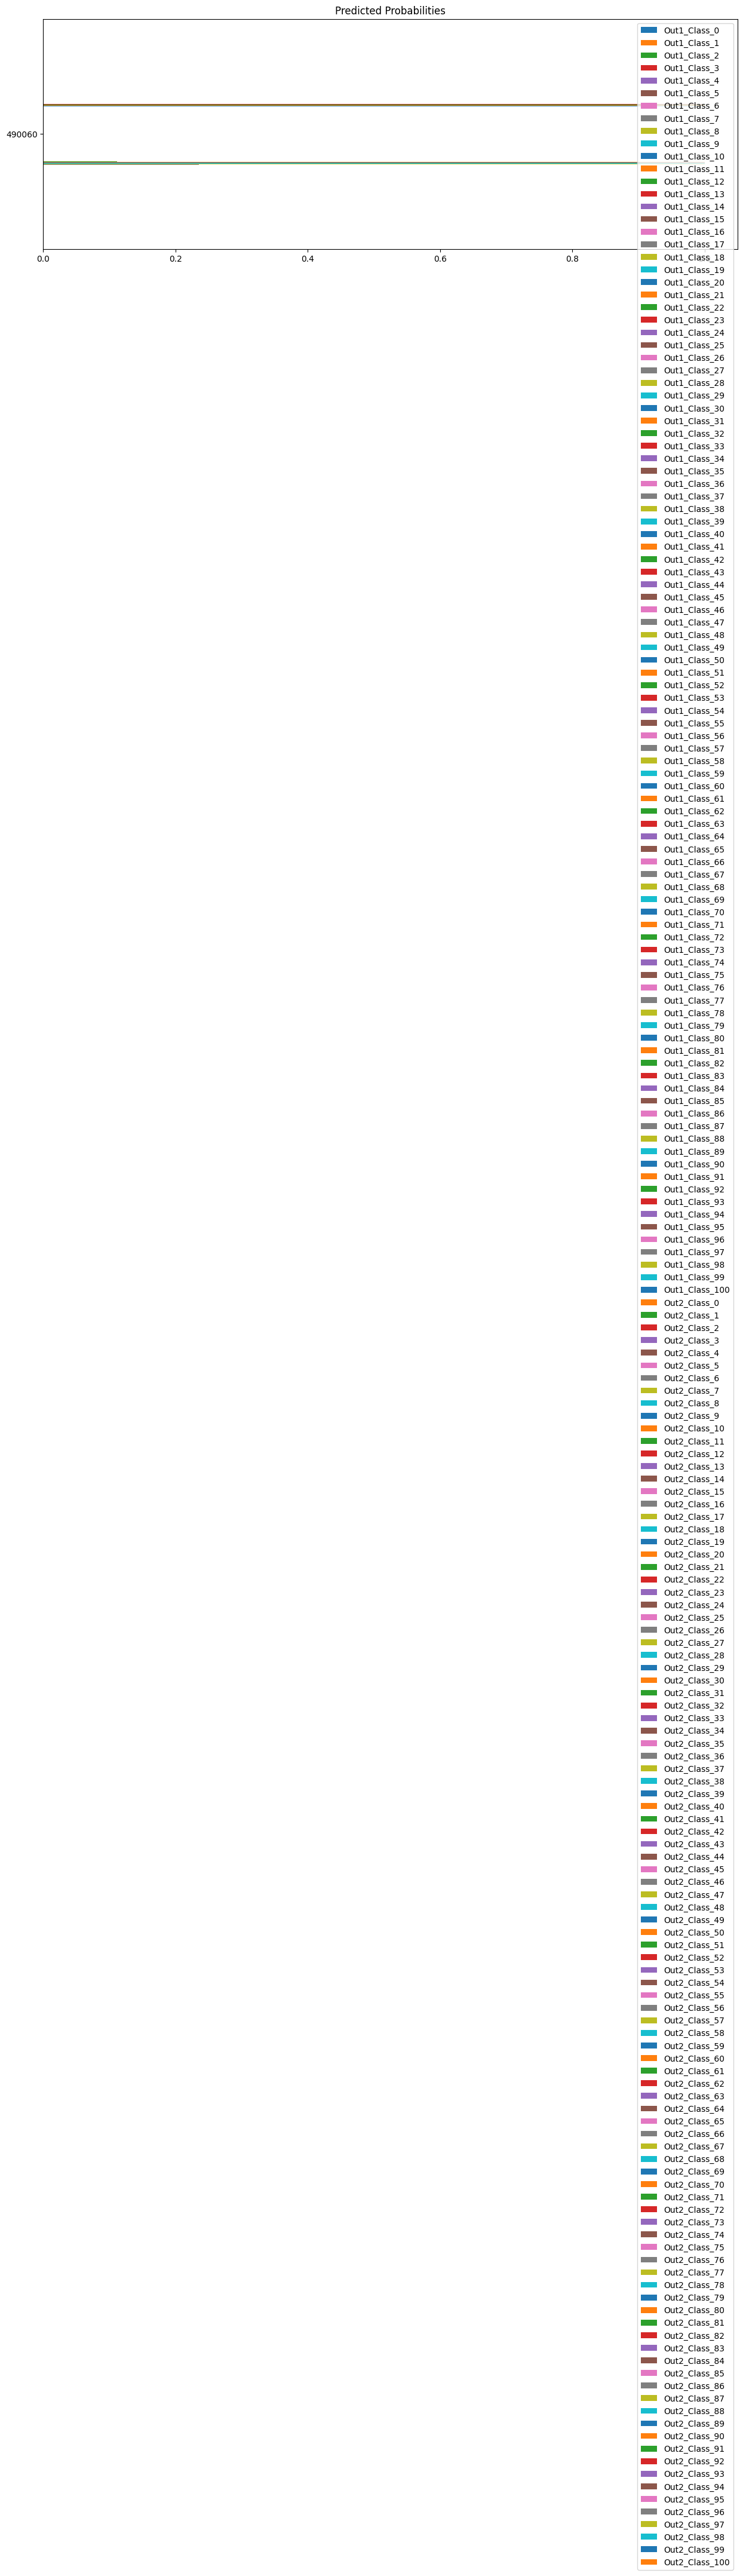

In [47]:
df_probabilities.drop(['True_Class1', 'True_Class2', 'Predicted_Class1', 'Predicted_Class2'], axis=1).sample(1).plot(kind='barh', figsize=(15, 5), title='Predicted Probabilities');

In [44]:
df_probabilities.drop(['True_Class1', 'True_Class2', 'Predicted_Class1', 'Predicted_Class2'], axis=1).sample(8).sum(axis=1)

503996     9.234309
437561     9.134552
128256     8.020501
509200     8.105957
499474     8.901340
494983    10.060850
399455    10.075443
479739     8.179779
dtype: float32

In [17]:
df_probabilities.describe()['Out1_Class_50']

count    5.542640e+05
mean     1.000000e+00
std      8.884281e-09
min      9.999988e-01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: Out1_Class_50, dtype: float64

In [18]:
new_data = torch.FloatTensor(np.random.rand(1, input_size))
with torch.no_grad():
    probabilities = model(new_data)
    probs1 = probabilities[0, :N_DISCRETIZATION].numpy()
    probs2 = probabilities[0, N_DISCRETIZATION:].numpy()
    predicted_class1 = np.argmax(probs1)
    predicted_class2 = np.argmax(probs2)
    predicted_value1 = undiscretize_vec(predicted_class1)
    predicted_value2 = undiscretize_vec(predicted_class2)
    print(f"\nSingle Prediction Example:")
    print(f"Input: {new_data.numpy()}")
    print(f"Predicted class 1: {predicted_class1}, Predicted value 1: {predicted_value1}")
    print(f"Predicted class 2: {predicted_class2}, Predicted value 2: {predicted_value2}")
    print(f"Class probabilities 1: {probs1}")
    print(f"Class probabilities 2: {probs2}")


Single Prediction Example:
Input: [[0.24494398 0.2569813  0.27083084 0.2503808  0.57059014 0.07521072
  0.5562891  0.71973145 0.66062707 0.5778532  0.08835156 0.17969693
  0.49916667 0.293767   0.8777775  0.3698361  0.00872381 0.06696036
  0.13415647 0.6728004  0.15120707 0.59464175 0.15161264 0.3496164
  0.05970281 0.5660008  0.66510487 0.499468   0.92166185 0.00260807
  0.79884624 0.7188243  0.6518984  0.28830138 0.2377884  0.8403686
  0.5341598  0.13024276 0.7170551  0.16494203 0.95366263 0.90290004
  0.18015152 0.5164538  0.3363323  0.02214619 0.8447246 ]]
Predicted class 1: 47, Predicted value 1: -0.01200000000000001
Predicted class 2: 48, Predicted value 2: -0.008000000000000007
Class probabilities 1: [1.8985981e-25 1.7913625e-24 2.5986520e-25 6.8862459e-25 4.6569769e-26
 3.3267837e-25 1.1183622e-24 2.8486443e-25 3.7513923e-25 5.1911150e-25
 1.8438736e-25 2.5028678e-25 6.8565468e-25 9.4933302e-26 2.6657020e-25
 1.4941145e-25 1.5232760e-24 3.0160997e-25 1.2393593e-25 3.0333496e-2